In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import palettable as pltt
import seaborn as sns
from seaborn import palplot
from shapely.geometry import Point
import pandas as pd
import numpy as np

In [2]:
lsoas_london_link = "../../London_Data/ESRI/LSOA_2011_London_gen_MHW.shp" 
lsoas_london = gpd.read_file(lsoas_london_link)
#keeping only some columns
lsoas_london = lsoas_london[['LSOA11CD','geometry']]
lsoas_london.head()

LSOA11CD                                           geometry
0  E01000001  POLYGON ((532105.0919998939 182011.23, 532162....
1  E01000002  POLYGON ((532746.8130000263 181786.891000028, ...
2  E01000003  POLYGON ((532135.1449999654 182198.1190000199,...
3  E01000005  POLYGON ((533807.9460001207 180767.7700000888,...
4  E01000006  POLYGON ((545122.048999952 184314.931000118, 5...

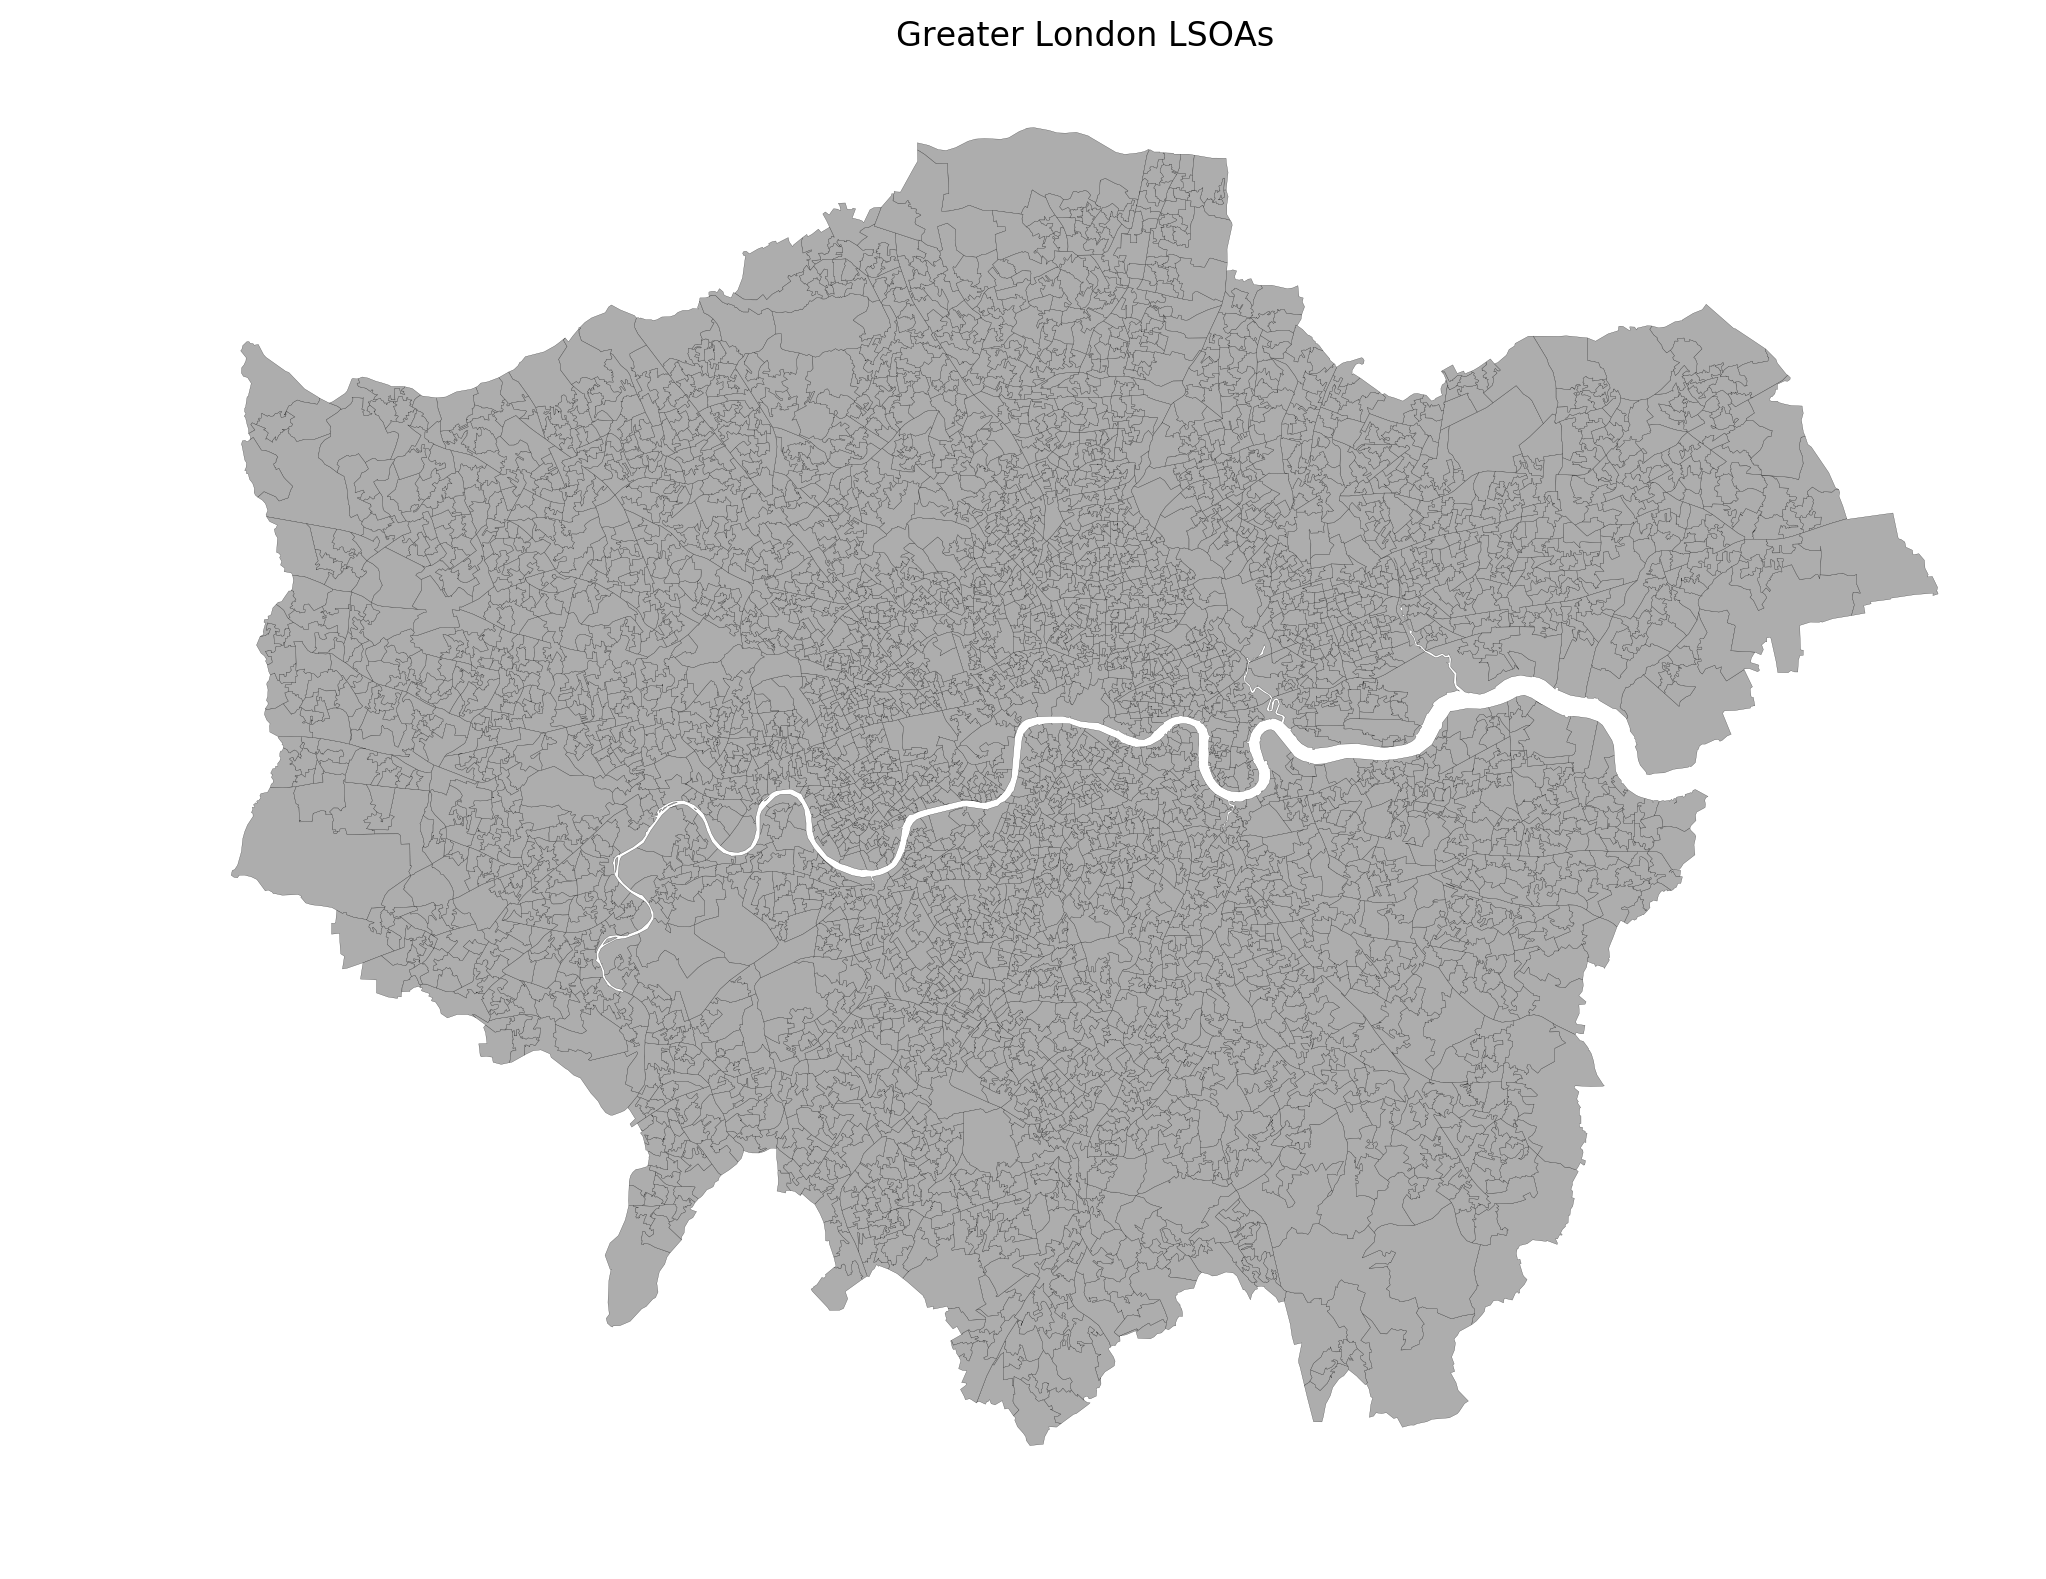

In [11]:
f, ax = plt.subplots(1, figsize=(12., 8.), dpi=200, subplot_kw=dict(aspect='equal'))
ax.axis('off')
lsoas_london.plot(ax=ax, linewidth=0.1, facecolor='#999999', edgecolor='#111111', alpha=0.8)
plt.title('Greater London LSOAs')
plt.tight_layout()

In [3]:
#Reading 3circles data
FILE_NAME = "../../../Data/London_venue_info_v2.csv" 
USE_COLS = ['lat', 'lng', 'category']

#with pandas
df = pd.read_csv(FILE_NAME, delimiter=",", usecols=USE_COLS)
#to geopandas
places_london = gpd.GeoDataFrame(df.drop(['lat', 'lng'], axis=1),
                                 crs={'init': 'epsg:4326'},
                                 geometry=[Point(x, y) for x, y in zip(df.lng, df.lat)])
places_london.head()

category                                        geometry
0                Pubs   POINT (-0.1334339549238772 51.51759527965574)
1  Fish & Chips Shops  POINT (-0.06212838758232592 51.53586439687221)
2           Bus Lines   POINT (-0.1030677339855296 51.54342483205862)
3  Mobile Phone Shops                   POINT (-0.2215498 51.5091377)
4  French Restaurants                     POINT (-0.090007 51.436141)

In [5]:
#setting projection
lsoas_london = lsoas_london.to_crs({'proj': 'tmerc'})
places_london = places_london.to_crs({'proj': 'tmerc'})

['#D5E3D8', '#618A98', '#F9DA95', '#AE4B16', '#787064']


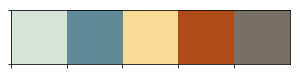

In [70]:
#palette
wes = pltt.wesanderson.Darjeeling2_5.hex_colors
palplot(wes)
print wes

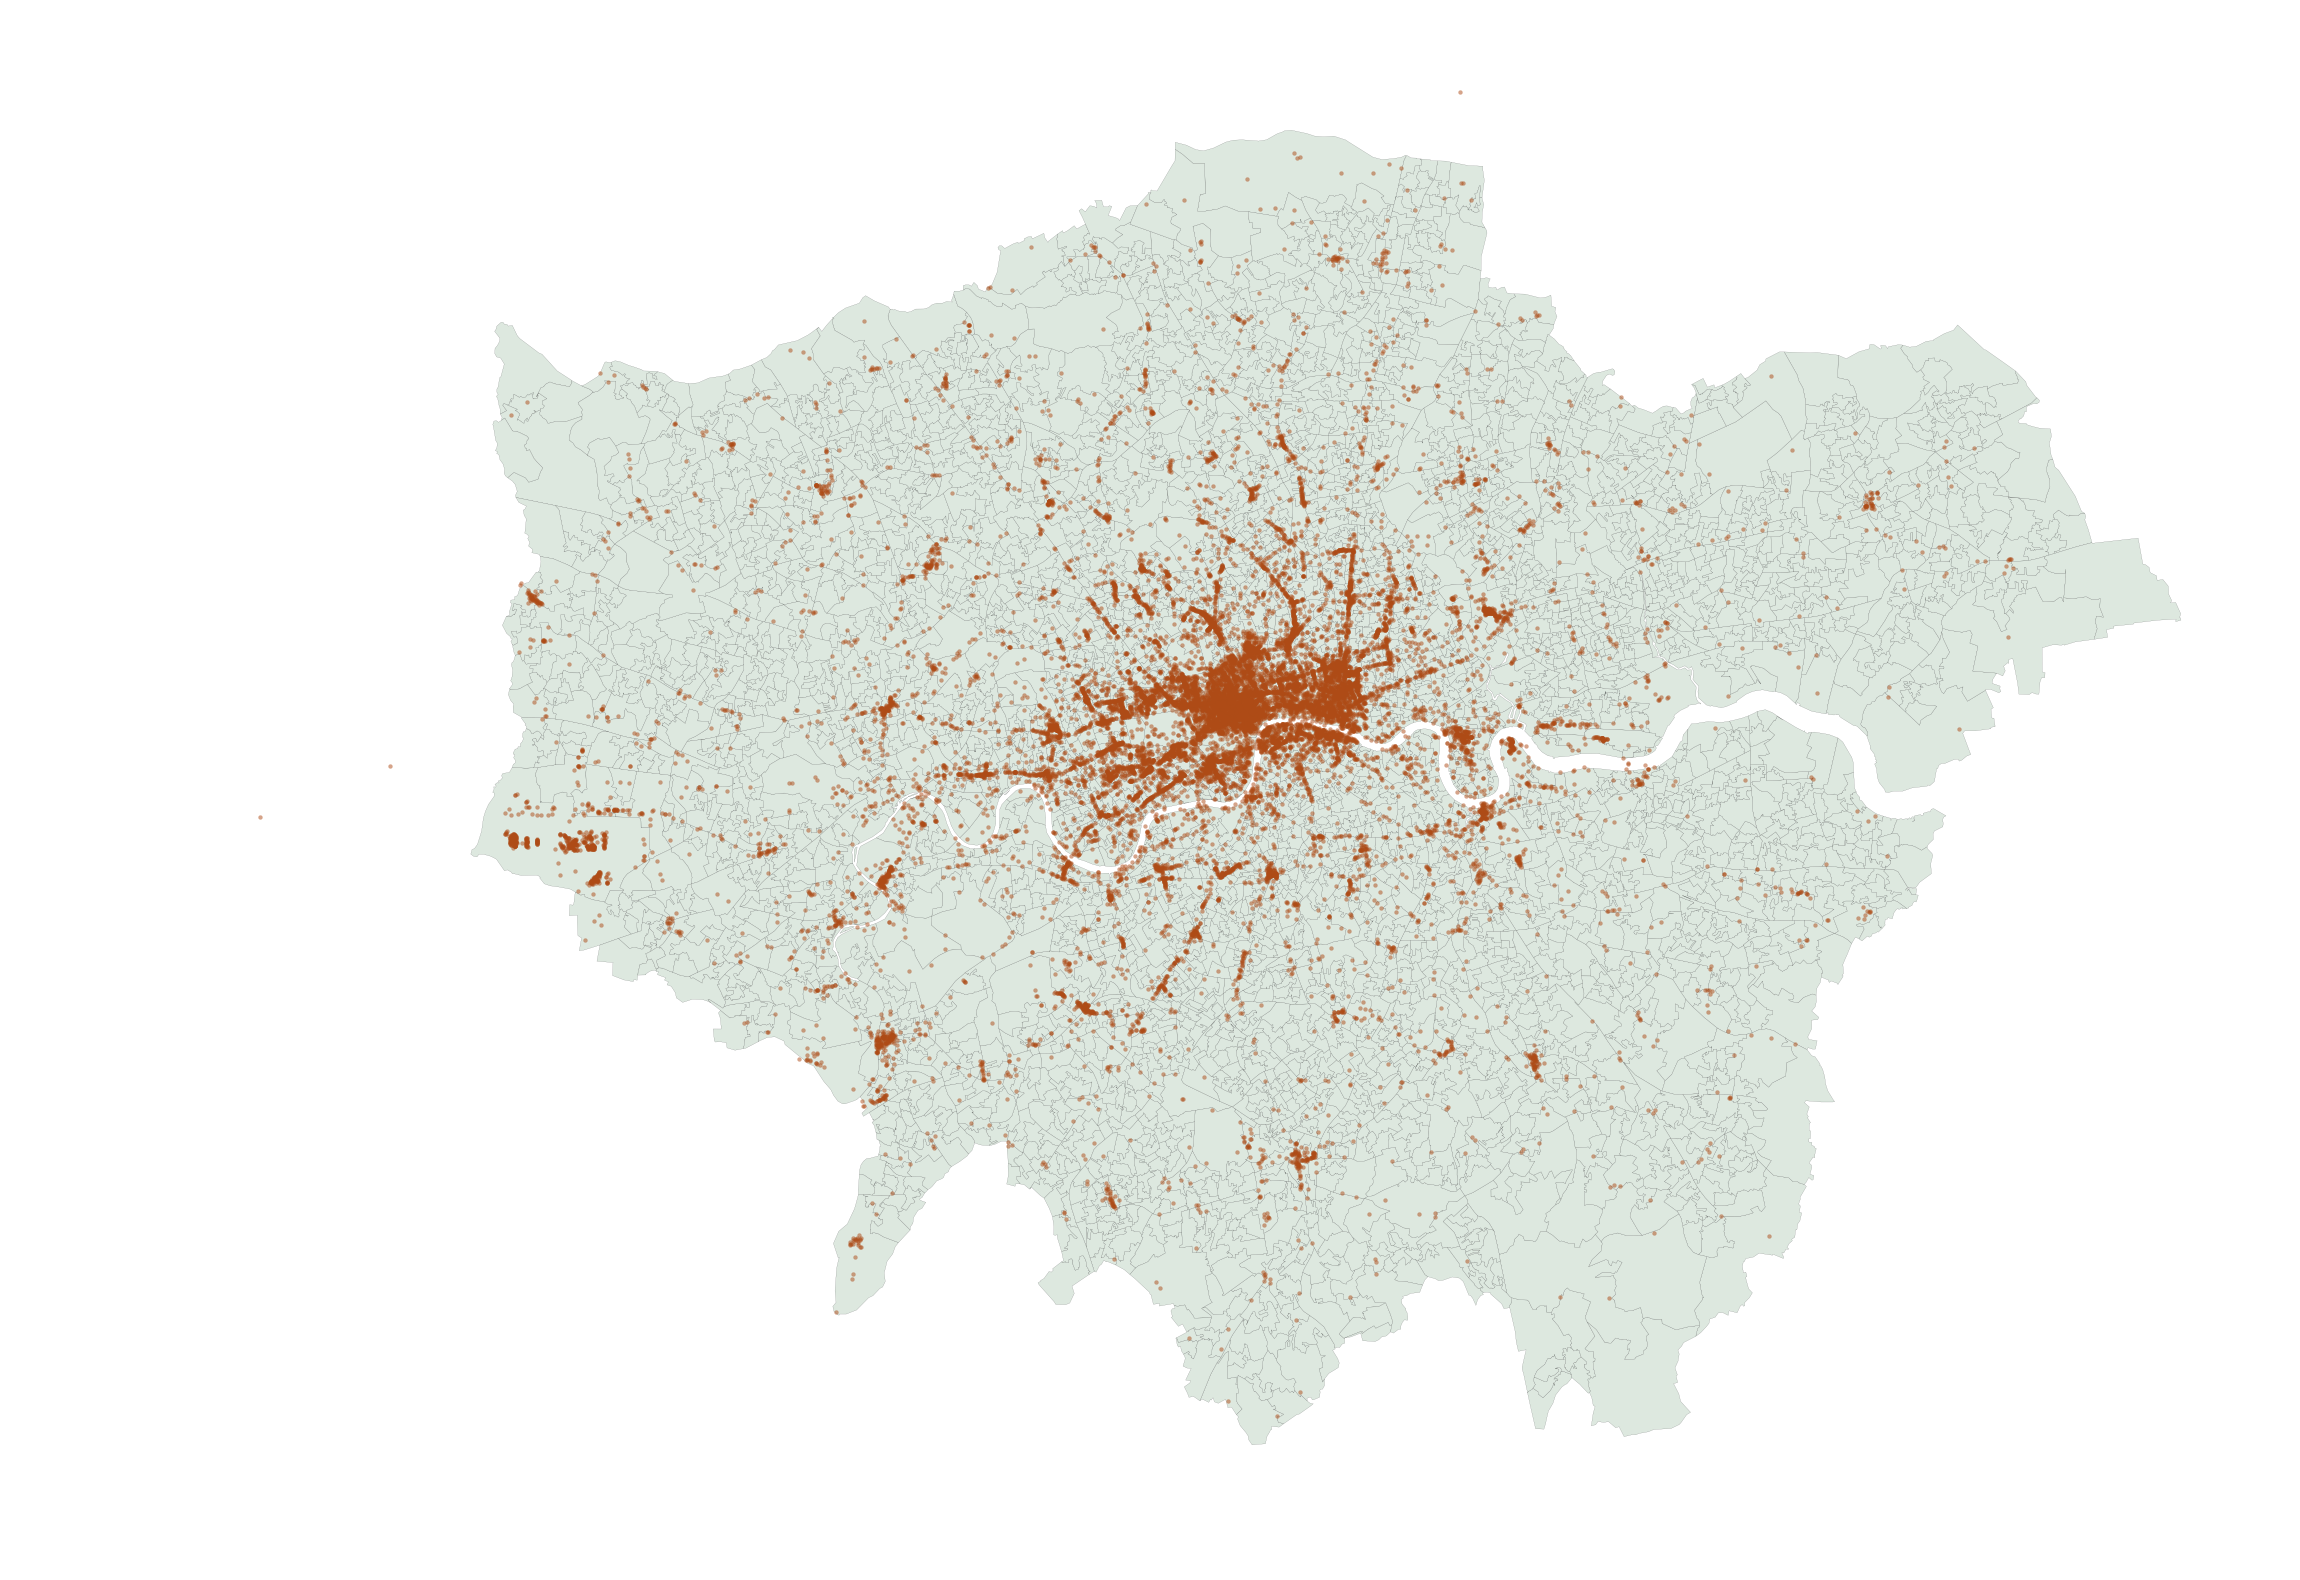

In [10]:
f, ax = plt.subplots(1, figsize=(12., 8.), dpi=200, subplot_kw=dict(aspect='equal'))
ax.axis('off')

lsoas_london.plot(ax=ax, linewidth=0.05, facecolor='#D5E3D8', edgecolor='#111111', alpha=0.8)
places_london.plot(ax=ax, linewidth=0.1, facecolor='#AE4B16', alpha=0.5, edgecolor='#AE4B16', markersize=2)

plt.tight_layout()

plt.savefig('../figures/london_LSOAs_plus_venues.png', dpi=200, transparent=True, tight_layout=True)

In [11]:
#Joining tables
jdf = gpd.sjoin(places_london, lsoas_london, how='right',op='within').reset_index()
jdf = jdf.drop(['index_right', 'index_left'], axis=1)
jdf.head()

category   LSOA11CD  \
0               Libraries  E01000001   
1                   Lakes  E01000001   
2           Cocktail Bars  E01000001   
3  Performing Arts Venues  E01000001   
4           Art Galleries  E01000001   

                                            geometry  
0  POLYGON ((-6640.876131843051 5710060.553200294...  
1  POLYGON ((-6640.876131843051 5710060.553200294...  
2  POLYGON ((-6640.876131843051 5710060.553200294...  
3  POLYGON ((-6640.876131843051 5710060.553200294...  
4  POLYGON ((-6640.876131843051 5710060.553200294...

In [12]:
cat_count = jdf.groupby('LSOA11CD', as_index=False).agg({'category': 'size', 'geometry': 'first'})
cat_count = gpd.GeoDataFrame(cat_count)
#
cat_count['logcatcount'] = np.log10(cat_count['category'])
cat_count.head()

LSOA11CD  category                                           geometry  \
0  E01000001        37  POLYGON ((-6640.876131843051 5710060.553200294...   
1  E01000002        77  POLYGON ((-6005.346420705409 5709818.696488084...   
2  E01000003        10  POLYGON ((-6605.717354470359 5710246.601913924...   
3  E01000005        36  POLYGON ((-4972.16861708077 5708770.679791695,...   
4  E01000006         1  POLYGON ((6437.580467144002 5712008.123041059,...   

   logcatcount  
0     1.568202  
1     1.886491  
2     1.000000  
3     1.556303  
4     0.000000

/Users/iacopo/.pyenv/versions/2.7.10/envs/jupytervenv/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


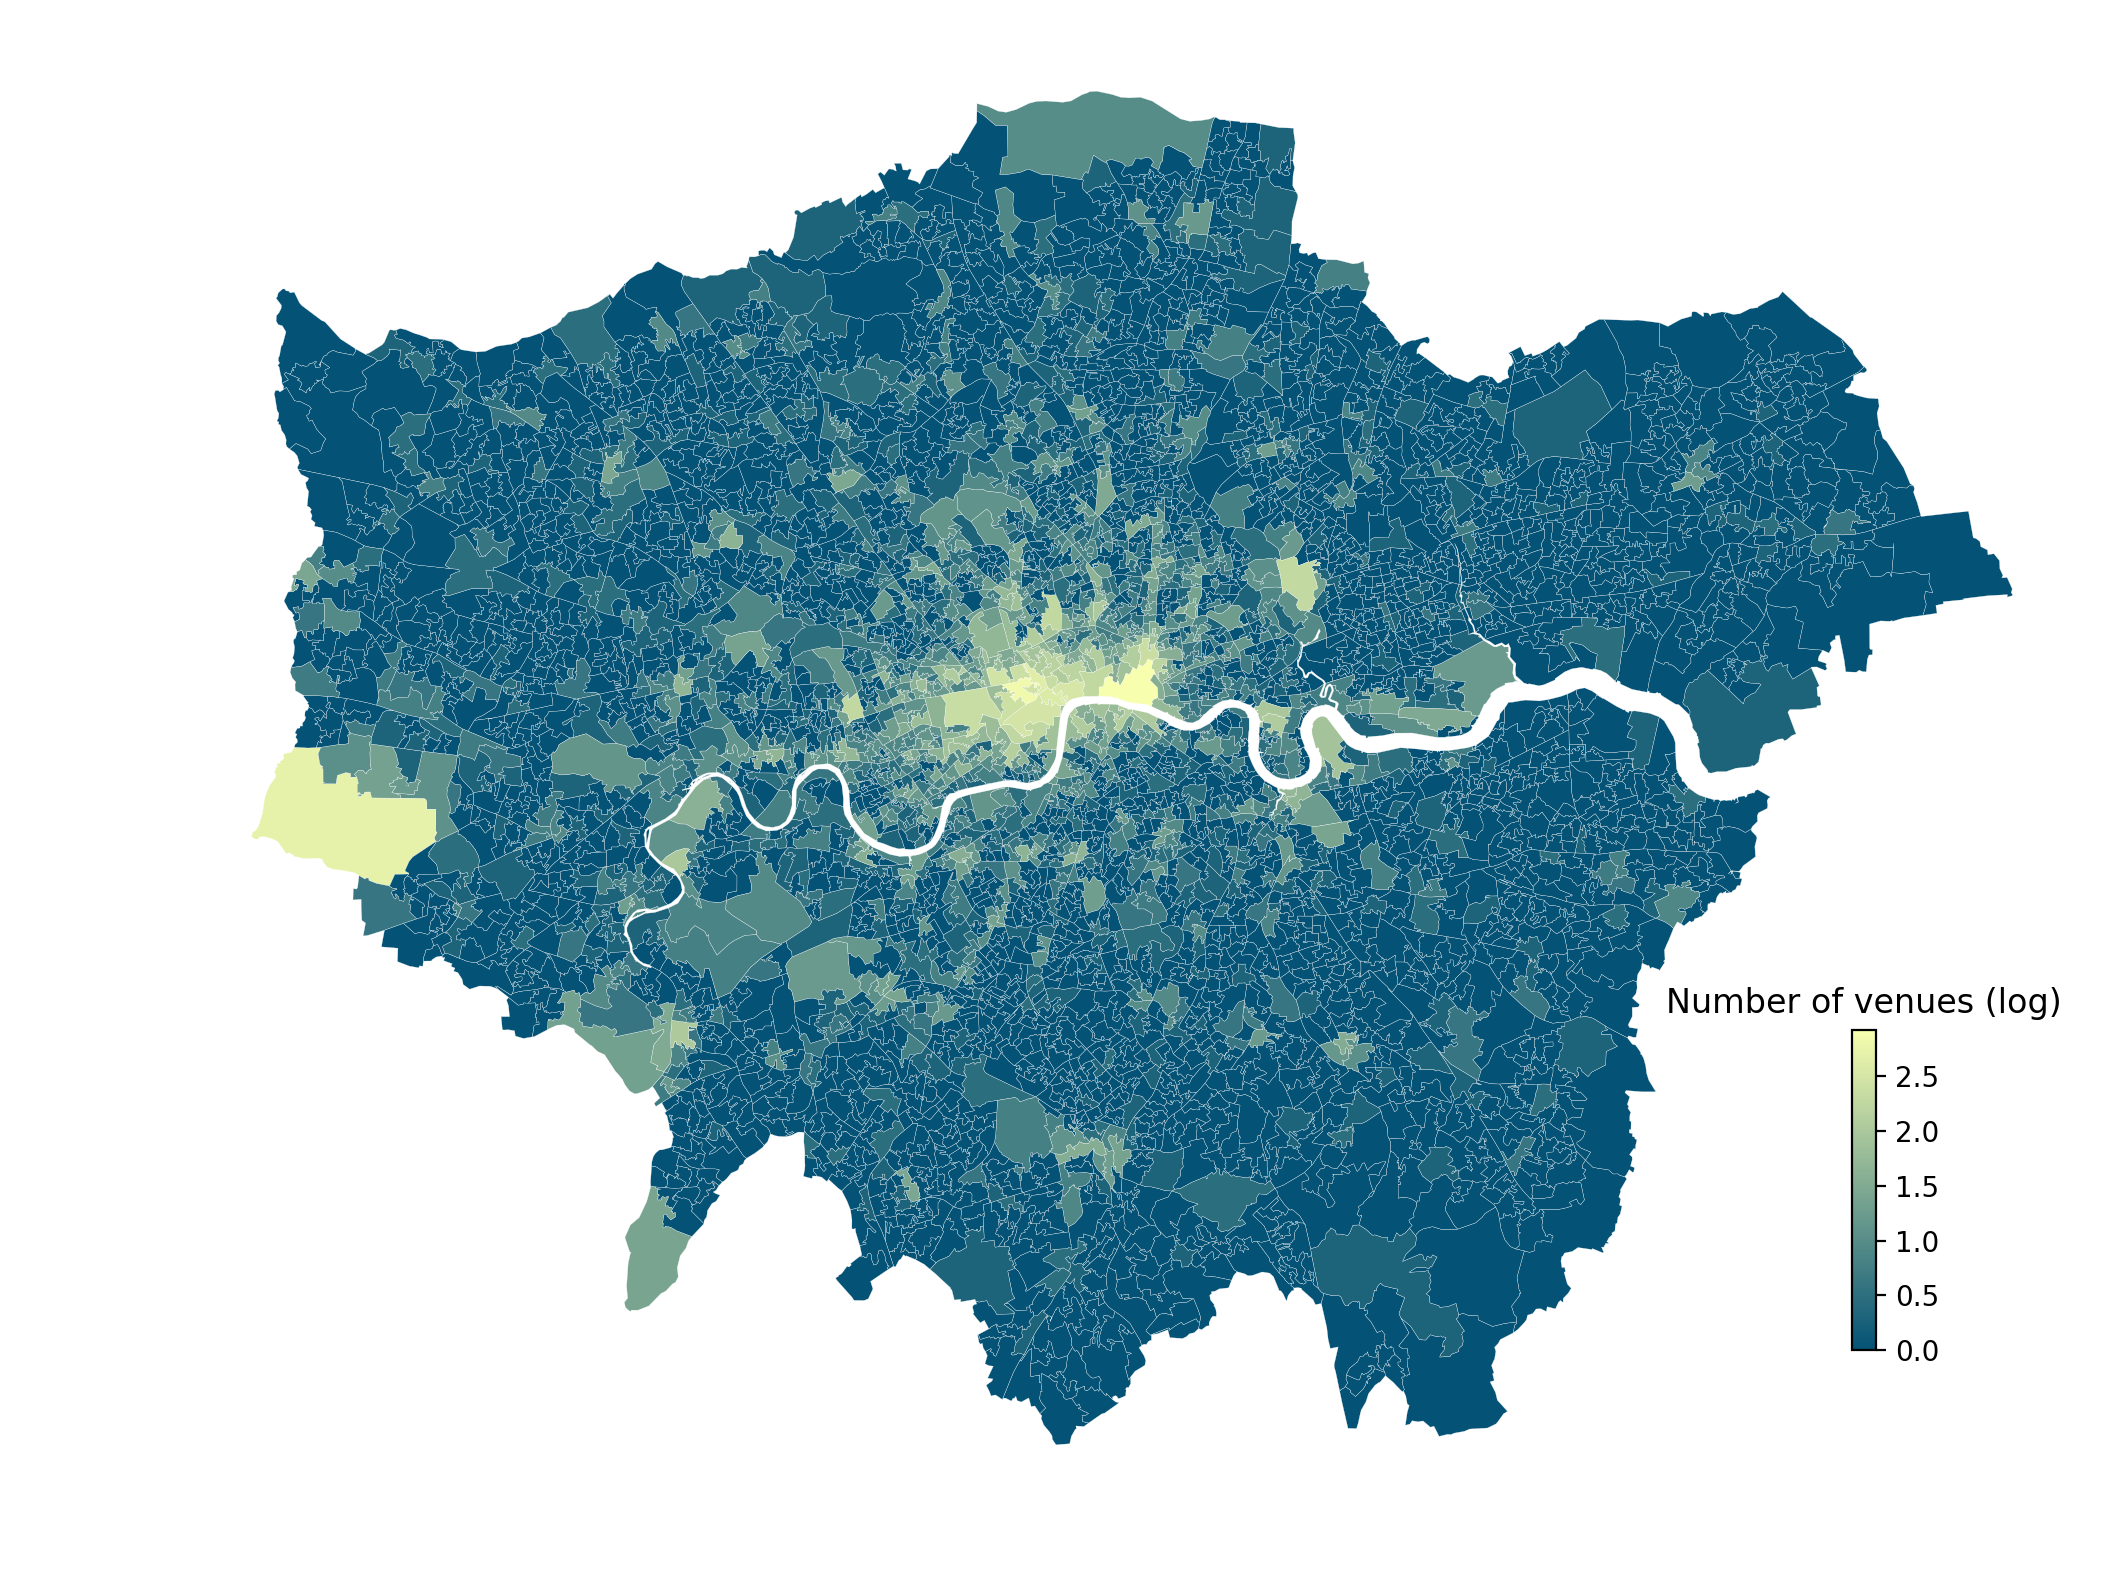

In [14]:
f, ax = plt.subplots(1, figsize=(12., 8.), dpi=200, subplot_kw=dict(aspect='equal'))
ax.axis('off')

#plotting
im = cat_count.plot(
    ax=ax,
    column='logcatcount', 
    k=7, 
    cmap= pltt.cartocolors.sequential.BluYl_2_r.mpl_colormap,
    alpha=1, 
    edgecolor='w', 
    linewidth=0.1, 
    legend=False, 
    antialiased=True)

#fixing colorbar
vmin = cat_count.logcatcount.min()
vmax = cat_count.logcatcount.max()
cax = f.add_axes([0.8, 0.15, 0.01, 0.2])
sm = plt.cm.ScalarMappable(cmap=pltt.cartocolors.sequential.BluYl_2_r.mpl_colormap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = f.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=10)

plt.title('Number of venues (log)')
plt.tight_layout()

plt.savefig('../figures/london_LSOAs_nvenues.png', dpi=200, transparent=True, tight_layout=True)